<a href="https://colab.research.google.com/github/soniapetrini/ADM_deep_learning/blob/main/ADM_project_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
import opendatasets as od
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import csv 
import time
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D

import matplotlib.pyplot as plt
import os
from tensorflow import keras

import cv2
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
od.download('https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic-v2')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: soniapetrini
Your Kaggle Key: ··········


100%|██████████| 2.18G/2.18G [00:21<00:00, 107MB/s]


Our first step is to collect all the paths with the related label, and split them into training, validation, and test set. 

- create paths df
- split in train, valid, test
- transform valid and test

In [ ]:
# preparation
common_dir = 'comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/'
classes = ['comics','faces']

# paths to all data
paths = {}    
for cl in classes:
  for f in os.listdir(common_dir+cl):
    paths[f'{common_dir}{cl}/{f}'] = classes.index(cl)

# labelled dataframe
data_df = pd.DataFrame.from_dict(paths, 'index', columns = ['label'])

# shuffle and split paths and labels
tf.random.set_seed(42)
data_df.sample(frac=1)
X = data_df.index
Y = data_df['label']

In [ ]:
# split in train and test
paths_train, paths_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
# split train in train and valid
paths_train, paths_valid, Y_train, Y_valid = train_test_split(paths_train, Y_train, test_size=0.3)

# Image transformation
The original images have size = 1024x1024 and are in color, the typical approach involves reducing RGB colors to gray, and rescale the gray tones between 0 and 1. Moreover, we can probably work with a lower image resolution, and then play around with it to see how it impacts performance.


In [ ]:
size = (64,64)

def convert_paths_to_normalized_X(paths, size):
  X = []
  for p in paths:
    image   = cv2.imread(p, cv2.IMREAD_GRAYSCALE)                   # load image in greyscale
    resized = cv2.resize(image, size)/255                           # resize and normalize grey colors
    X.append(resized)

  return np.array(X).reshape(-1, size[0], size[1], 1)

# transform all valid paths and labels in arrays
X_valid = convert_paths_to_normalized_X(paths_valid, size)                
Y_valid = np.array(Y_valid)

Now we would like to know how much memory space do these objects use, as we are now dealing with "only" 2 GB of data, but if we want our programme to scale up we need to take both __time__ and __space__ into account. Indeed,processing an image takes some time, and thus we would like to only do this operation once, on all training, validation, and test data. However, we do not want to overload the memory, so, we first transform the validation set, which is the smallest of the three, and check its space in memory.

The set takes approximately 0,000152 MB, meaning that we can safely transform once also test and training sets, without a memory overhead.

In [ ]:
sys.getsizeof(X_valid)

152

In [ ]:
X_train  = convert_paths_to_normalized_X(paths_train, size)
Y_train  = np.array(Y_train)
X_test   = convert_paths_to_normalized_X(paths_test, size)
Y_test   = np.array(Y_test)

In [ ]:
# check all shapes
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(9800, 64, 64, 1)
(9800,)
(4200, 64, 64, 1)
(4200,)
(6000, 64, 64, 1)
(6000,)


# First model design

In [46]:
# ~ FUNCTIONS ~

# define model function
def build_model(first_layer_size, which_pool, n_conv):
  model = Sequential()
  model.add(Dense(first_layer_size, activation = 'relu',input_shape = X_train.shape[1:]))       # fixed Dense layer

  if (which_pool == 'max'):                                                                     # pooling, max or average?
    pool_layer = MaxPooling2D(pool_size=(2, 2))
  else:
    pool_layer = AveragePooling2D(pool_size=(2, 2))

  if ( n_conv in [1,2,3] ):                                                                     # add convolution layers 
    model.add(Conv2D(32, (3, 3)))
    model.add(pool_layer)
  if ( n_conv in [2,3] ): 
    model.add(Conv2D(64, (3, 3)))
    model.add(pool_layer)
  if ( n_conv in [3]) : 
    model.add(Conv2D(128, (3, 3)))
    model.add(pool_layer)

  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))                                                   # fixed final classification layer

  return model


# add f-score to history
def add_fscore(history):
  fscores     = []
  val_fscores = []
  for i in range(n_epochs):
    for which in ['val_','']:
      precision = history[f'{which}precision'][i]
      recall = history[f'{which}recall'][i]
      fscore =  2 * (precision * recall) / (precision + recall)
      if which == '':
        fscores.append(fscore)
      else:
        val_fscores.append(fscore)

  history['f-score'] = fscores
  history['val_f-score'] = val_fscores
  return history


# plot selected model's history
def plot_history(net_name):
  history_ = pickle.load(open('/trainHistoryDict'+ net_name, "rb"))
  history_ = add_fscore(history_)

  f = plt.figure(figsize=(10,6))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)

  # loss
  ax.plot(history_['loss'])
  ax.plot(history_['val_loss'])
  ax.grid(True)
  ax.set_title("loss")
  ax.legend(['train', 'validation'], loc='upper right')

  # f-score
  ax2.plot(history_['f-score'])
  ax2.plot(history_['val_f-score'])
  ax2.grid(True)
  ax2.set_title("f-score")
  ax2.legend(['train', 'validation'], loc='lower right')


In [ ]:
# PERFORM GRID SEARCH!

first_layer_sizes = [16, 32, 64]
which_pools = ['average','max']
n_convs = [1,2,3]
n_epochs = 1

for first_layer_size in first_layer_sizes:
  for which_pool in which_pools:
      for n_conv in n_convs:

        net_name = f'{first_layer_size}_{which_pool}_{n_conv}'

        # build model
        model = build_model(first_layer_size,which_pool,n_conv)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision','Recall'])
      
        # train it
        start = time.time()
        history = model.fit(X_train, Y_train, batch_size=32,
                            epochs=n_epochs, validation_data=(X_valid,Y_valid))
        end = time.time()

        # write times to file
        filename = 'times.csv'
        file_exists = os.path.isfile(filename)

        with open(filename, "a") as time_f:
          writer = csv.DictWriter(time_f, fieldnames=['net','time'])
          if not file_exists:
            writer.writeheader()
          writer.writerow({'net':net_name, 'time':end-start})

        # write history to file
        with open('/trainHistoryDict' + net_name, 'wb') as history_f:
                pickle.dump(history.history, history_f)


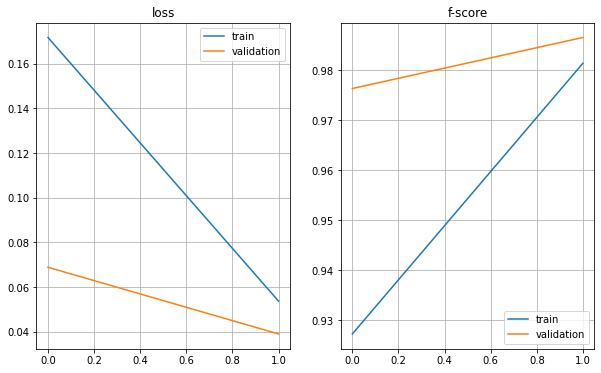

In [95]:
plot_history(net_name)

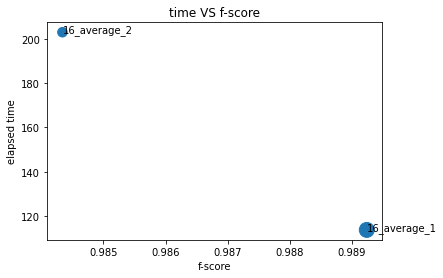

In [117]:
3 # PLOT TIME VS LAST val f-score

# load df with names and times
nets_df = pd.read_csv('times.csv')

# access last fscore
last_val_fscores  = []
for i, name in enumerate(nets_df['net']):
    history = pickle.load(open('/trainHistoryDict'+ name, "rb"))
    history = add_fscore(history)
    last_val_fscores.append(history['val_f-score'][n_epochs-1])

nets_df['val_f-score'] = last_val_fscores

# add size?
#nets_df['img_size'] = [s**1.3 for s in [64,32]]


# plot!
fig, ax = plt.subplots()
ax.scatter(nets_df['val_f-score'], nets_df['time'])
ax.set_title("time VS f-score")
ax.set_xlabel("f-score")
ax.set_ylabel("elapsed time")

for i, txt in enumerate(nets_df['net']):
    ax.annotate(txt, (nets_df['val_f-score'][i], nets_df['time'][i]))

plt.savefig('time_vs_fscore.pdf')